# Faster RCNN
lis2/gym_client/examples/notebookフォルダで動くかテスト

In [1]:
import sys
sys.path.append('../../../../chainer-faster-rcnn')

In [2]:
from chainer import serializers
from chainer.cuda import to_gpu
from lib.cpu_nms import cpu_nms as nms
from lib.models.faster_rcnn import FasterRCNN

import argparse
import sys; sys.argv=['']; del sys

import chainer
import cv2 as cv
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import print_function

In [3]:
class FasterRCNNContainer():
    CLASSES = ('__background__',
               'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor')
    PIXEL_MEANS = np.array([[[102.9801, 115.9465, 122.7717]]])


    def __init__(self, gpu=-1):
        xp = chainer.cuda.cupy if chainer.cuda.available and args.gpu >= 0 else np
        self.model = FasterRCNN(gpu)
        self.model.train = False
        serializers.load_npz('data/VGG16_faster_rcnn_final.model', self.model)
        if chainer.cuda.available and gpu >= 0:
            self.model.to_gpu(gpu)
        self.gpu = gpu
        
    def imread(self, img_fname):
        orig_image = cv.imread(img_fname)
        max_size=1000
        scale=800
        im_size_min = np.min(orig_image.shape[0:2])
        im_size_max = np.max(orig_image.shape[0:2])
        im_scale = float(scale) / float(im_size_min)
        if np.round(im_scale * im_size_max) > max_size:
            im_scale = float(max_size) / float(im_size_max)
        orig_image = cv.resize(orig_image, None, None, fx=im_scale, fy=im_scale,
                        interpolation=cv.INTER_LINEAR)
        return orig_image
    
    def forward(self, orig_image):
        img, im_scale = self.img_preprocessing(orig_image, self.PIXEL_MEANS)
        img = np.expand_dims(img, axis=0)
        if self.gpu >= 0:
            img = to_gpu(img, device=self.gpu)
        img = chainer.Variable(img, volatile=True)
        h, w = img.data.shape[2:]
        cls_score, bbox_pred = self.model(img, np.array([[h, w, im_scale]]))
        cls_score = cls_score.data
        return cls_score, bbox_pred, im_scale

    def img_preprocessing(self, orig_img, pixel_means, max_size=1000, scale=600):
        img = orig_img.astype(np.float32, copy=True)
        img -= pixel_means
        im_size_min = np.min(img.shape[0:2])
        im_size_max = np.max(img.shape[0:2])
        im_scale = float(scale) / float(im_size_min)
        if np.round(im_scale * im_size_max) > max_size:
            im_scale = float(max_size) / float(im_size_max)
        img = cv.resize(img, None, None, fx=im_scale, fy=im_scale,
                        interpolation=cv.INTER_LINEAR)

        return img.transpose([2, 0, 1]).astype(np.float32), im_scale


    def draw_result(self, out, im_scale, clss, bbox, nms_thresh=0.3, conf=0.8):
        if self.gpu >= 0:
            clss = chainer.cuda.cupy.asnumpy(clss)
            bbox = chainer.cuda.cupy.asnumpy(bbox)
        
        CV_AA = 16
        fontScale = 0.8
        result = out.copy()
        for cls_id in range(1, 21):
            _cls = clss[:, cls_id][:, np.newaxis]
            _bbx = bbox[:, cls_id * 4: (cls_id + 1) * 4]
            dets = np.hstack((_bbx, _cls))
            keep = nms(dets, nms_thresh)
            dets = dets[keep, :]

            inds = np.where(dets[:, -1] >= conf)[0]
            for i in inds:
                x1, y1, x2, y2 = map(int, dets[i, :4])
                cv.rectangle(result, (x1, y1), (x2, y2), (0, 0, 255), 2, CV_AA)
                disp_text = "{0}:{1:.3f}".format(self.CLASSES[cls_id], dets[i, 4])
                ret, baseline = cv.getTextSize( disp_text, cv.FONT_HERSHEY_SIMPLEX, fontScale, 1)
                cv.rectangle(result, (x1, y2 - ret[1] - baseline),
                             (x1 + ret[0], y2), (0, 0, 255), -1)
                cv.putText(result, disp_text, (x1, y2 - baseline),
                           cv.FONT_HERSHEY_SIMPLEX, fontScale, (255, 255, 255), 1, CV_AA)

        return result

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('--img_fn', type=str, default='sample.jpg')
parser.add_argument('--out_fn', type=str, default='result.jpg')
parser.add_argument('--nms_thresh', type=float, default=0.3)
parser.add_argument('--conf', type=float, default=0.8)
parser.add_argument('--gpu', type=int, default=0)
args = parser.parse_args()

In [5]:
rcnn = FasterRCNNContainer(args.gpu)

In [6]:
def show(cv_mat):
    plt.imshow(cv.cvtColor(cv_mat, cv.COLOR_BGR2RGB))

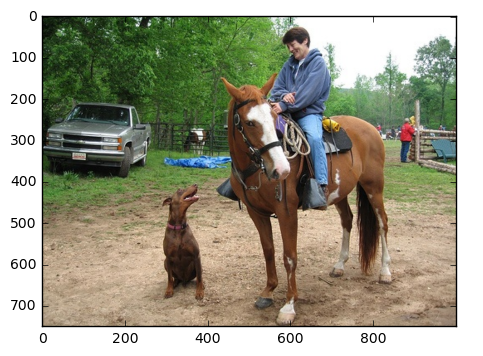

In [7]:
orig_image = rcnn.imread(args.img_fn)
show(orig_image)

In [8]:
cls_score, bbox_pred, im_scale = rcnn.forward(orig_image)

In [9]:
cls_id = 13
rcnn.CLASSES[cls_id]

'horse'

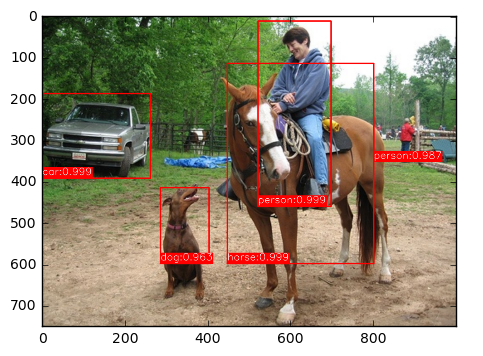

In [11]:
result = rcnn.draw_result(orig_image, im_scale, cls_score, bbox_pred,
                     args.nms_thresh, args.conf)
cv.imwrite(args.out_fn, result)
show(result)

# 以下メモ書き

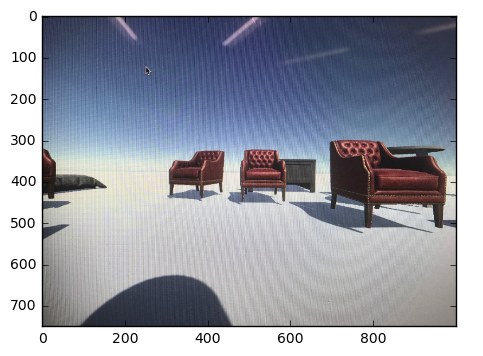

In [11]:
img_fname = "0.jpg"
orig_image = imread(img_fname)
show(orig_image)

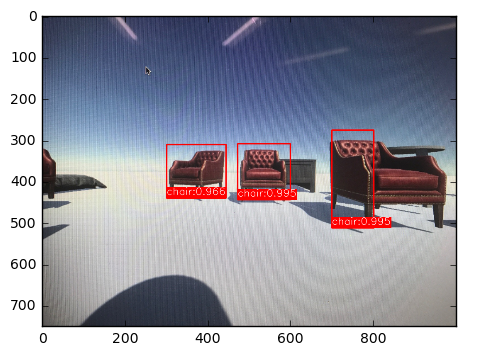

In [12]:
img, im_scale = img_preprocessing(orig_image, PIXEL_MEANS)
img = np.expand_dims(img, axis=0)
if args.gpu >= 0:
    img = to_gpu(img, device=args.gpu)
img = chainer.Variable(img, volatile=True)

h, w = img.data.shape[2:]
cls_score, bbox_pred = model(img, np.array([[h, w, im_scale]]))
cls_score = cls_score.data

h, w = img.data.shape[2:]
cls_score, bbox_pred = model(img, np.array([[h, w, im_scale]]))
cls_score = cls_score.data

if args.gpu >= 0:
    cls_score = chainer.cuda.cupy.asnumpy(cls_score)
    bbox_pred = chainer.cuda.cupy.asnumpy(bbox_pred)
result = draw_result(orig_image, im_scale, cls_score, bbox_pred,
                     0.4, 0.7)
cv.imwrite(args.out_fn, result)
show(result)

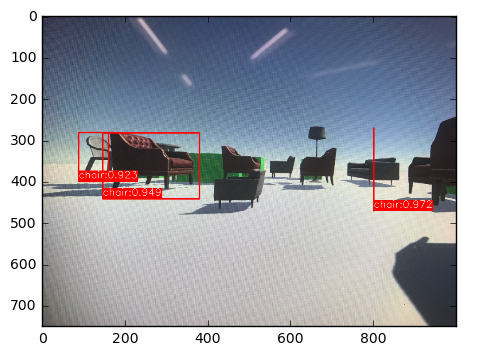

In [14]:
for i in range(7):
    img_fname = str(i)+".jpg"
    orig_image = imread(img_fname)
    img, im_scale = img_preprocessing(orig_image, PIXEL_MEANS)
    img = np.expand_dims(img, axis=0)
    if args.gpu >= 0:
        img = to_gpu(img, device=args.gpu)
    img = chainer.Variable(img, volatile=True)

    h, w = img.data.shape[2:]
    cls_score, bbox_pred = model(img, np.array([[h, w, im_scale]]))
    cls_score = cls_score.data

    h, w = img.data.shape[2:]
    cls_score, bbox_pred = model(img, np.array([[h, w, im_scale]]))
    cls_score = cls_score.data

    if args.gpu >= 0:
        cls_score = chainer.cuda.cupy.asnumpy(cls_score)
        bbox_pred = chainer.cuda.cupy.asnumpy(bbox_pred)
    result = draw_result(orig_image, im_scale, cls_score, bbox_pred,
                         0.5, 0.7)
    out_img = "result"+  str(i)+".jpg"
    cv.imwrite(out_img, result)
    show(result)